## ResNets
---

### Motivation: Problem of Very Deep Neural Networks

* Deep networks can represent very complex functions and learn features at many different levels of abstraction, from edges (at layers closer to the input) to complex features (at deeper layers). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow. More specifically, during gradient descent, as we backpropagate, we are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode").

* Therefore, during training, the magnitude (or norm) of the gradient for shallower layers may decrease to zero very rapidly as training proceeds: 
<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">

### ResNet solves this issue by allowing 'skip' connections

* This allows for (1) smooth flow of gradients up the network, and (2) little harm from stacking additional blocks, because they can easily learn to become an identify function (and become redundant)

<img src="images/skip_connection_kiank.png" style="width:400px;height:150px;">


### Types:
(1) **Identify block** - is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$)

(2) **Convolution block** - there is a CONV2D layer in the shortcut path, and input and output dimensions don't match up.

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <font color='purple'> <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center><font color='purple'>  : <b>Convolutional block</b> </center></caption>
    
### References:
- [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) - [Add layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)
- [Initializer function](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) - by default it will be set to [random_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform)


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
%matplotlib inline

# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
# from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
# from tensorflow.python.framework.ops import EagerTensor

In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- list of integers, defining  number of filters in the CONV layers 
    training -- True: Behave in training mode. False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C), where n_C = F3
    """
    
    F1, F2, F3 = filters    # Unpack filter values
    X_shortcut = X          # Save the input value, to 'skip' forward
    
    # First component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    # Activation (Main path + Skip Connection)
    X = Add()([X, X_shortcut])                   # notice the syntax
    X = Activation('relu')(X)
    
    return X   # (nH, nW, F3) - if F3 is same as # of input channels, then shape is preserved

In [3]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode. False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Defaults to Glorot uniform initializer aka
                   Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters    # Unpack filter values
    X_shortcut = X          # Save the input value, to 'skip' forward
    
    # First component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    # main path would return (nH/s, nW/s, F3)
    
    # Skip Path
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    # Activation (Main path + Skip Connection)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X  # (nH/s, nW/s, F3)

## Building a ResNet Model (50 layers)

### Architecture: 

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <font color='purple'> <b>ResNet-50 model</b> </center></caption>

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns: model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) # nH+6, nw+6, nC
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X) # nH/2, nW/2, 64
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)  # ~(15, 15, 64)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])    # o/p = nH, nW, 256 <- determined by last value
    X = identity_block(X, 3, [64, 64, 256])    # which is kept same as o/p channels from conv layer

    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL
    X = AveragePooling2D((2,2))(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

## Hand Signs dataset

In [5]:
train = h5py.File('data/train_signs.h5', "r")
X_train = np.array(train["train_set_x"][:])
Y_train_orig = np.array(train["train_set_y"][:])

test = h5py.File('data/test_signs.h5', "r")
X_test = np.array(test["test_set_x"][:])
Y_test_orig = np.array(test["test_set_y"][:])

classes = np.array(test["list_classes"][:])

X_train = X_train/255.
X_test  = X_test/255.

Y_train = np.eye(6)[Y_train_orig]
Y_test = np.eye(6)[Y_test_orig]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


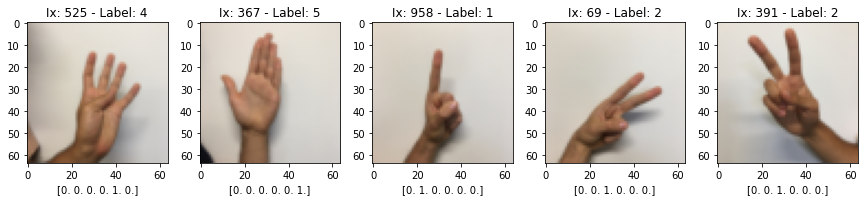

In [6]:
m = X_train.shape[0]

fig, axes = plt.subplots(1, 5, figsize=(12,5))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    index = np.random.randint(m)
    ax.imshow(X_train[index])
    ax.set_title("Ix: " + str(index) + " - Label: " + str(Y_train_orig[index]))
    ax.set_xlabel(str(Y_train[index]))

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
# print(model.summary())

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 32, validation_data=(X_test, Y_test))

Epoch 1/10
34/34 [==============================] - 33s 866ms/step - loss: 1.8795 - accuracy: 0.4935 - val_loss: 1.1776 - val_accuracy: 0.5250
Epoch 2/10
34/34 [==============================] - 25s 740ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.7885 - val_accuracy: 0.7500
Epoch 3/10
34/34 [==============================] - 25s 732ms/step - loss: 0.3936 - accuracy: 0.8602 - val_loss: 1.2063 - val_accuracy: 0.7917
Epoch 4/10
34/34 [==============================] - 25s 734ms/step - loss: 0.3362 - accuracy: 0.8917 - val_loss: 0.5469 - val_accuracy: 0.7917
Epoch 5/10
34/34 [==============================] - 26s 774ms/step - loss: 0.3050 - accuracy: 0.9056 - val_loss: 0.5457 - val_accuracy: 0.8333
Epoch 6/10
34/34 [==============================] - 28s 826ms/step - loss: 0.1623 - accuracy: 0.9472 - val_loss: 0.4101 - val_accuracy: 0.8667
Epoch 7/10
34/34 [==============================] - 30s 876ms/step - loss: 0.1383 - accuracy: 0.9593 - val_loss: 0.4652 - val_accuracy: 0.8917

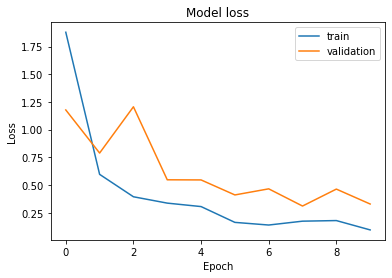

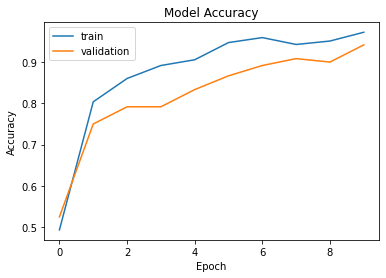

In [10]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']].rename(columns ={'loss':'train','val_loss':'validation'})
df_acc= df_loss_acc[['accuracy','val_accuracy']].rename(columns = {'accuracy':'train','val_accuracy':'validation'})

df_loss.plot(title='Model loss').set(xlabel='Epoch',ylabel='Loss');
df_acc.plot(title='Model Accuracy').set(xlabel='Epoch',ylabel='Accuracy');

In [11]:
# model.evaluate(X_test, Y_test)
y_pred = model.predict(X_test)
y_pred_class = np.array([np.argmax(i) for i in y_pred])

from sklearn.metrics import classification_report
print(classification_report(Y_test_orig, y_pred_class))

4/4 [==============================] - 2s 176ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.87      1.00      0.93        20
           2       1.00      0.70      0.82        20
           3       0.91      1.00      0.95        20
           4       0.90      0.95      0.93        20
           5       1.00      1.00      1.00        20

    accuracy                           0.94       120
   macro avg       0.95      0.94      0.94       120
weighted avg       0.95      0.94      0.94       120



---
## Author's pre-trained model

In [15]:
pre_trained_model = tf.keras.models.load_model('pretrainedmodel/resnet50.h5')

y_ = pre_trained_model.predict(X_test)
y_class = np.array([np.argmax(i) for i in y_])

print(classification_report(Y_test_orig, y_class))

4/4 [==============================] - 1s 146ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      1.00      0.98        20
           2       1.00      0.80      0.89        20
           3       1.00      1.00      1.00        20
           4       0.83      0.95      0.88        20
           5       0.95      0.95      0.95        20

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



---
## Intermediate output from Stage # 1 for a sample image

TensorShape([1, 15, 15, 64])

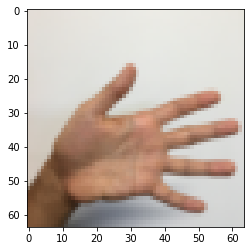

In [13]:
im_ix = 0

plt.imshow(X_train[im_ix])

intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                          outputs=model.layers[5].output)
intermediate_output = intermediate_layer_model(X_train[im_ix].reshape(-1,64,64,3))

intermediate_output.shape

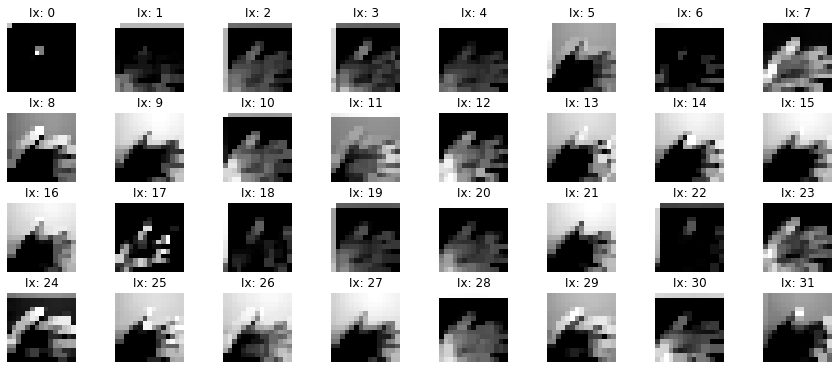

In [14]:
fig, axes = plt.subplots(4, 8, figsize=(12,5))
fig.tight_layout(pad=0)
for i,ax in enumerate(axes.flat):
    ax.imshow(intermediate_output[0,:,:,i], cmap='gray')
    ax.set_title("Ix: " + str(i))
    ax.set_axis_off()